<a href="https://colab.research.google.com/github/clarakl/UoA-GEOG761/blob/main/761_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Deep Learning for Satellite Data
This notebook uses a pre-made training dataset to develop a simple deep learning classifier for finding solar pannels in Sentinel 2 imagery. The learning objectives for this lab are to:

1. Load and use a pre-labeled training dataset (e.g. polygons or patches with land cover classes).
2. Prepare that data for use in a deep learning model.
3. Train a deep learning model in TensorFlow/Keras using these labels.

At the end of the lab you will be asked to reflect on model performance, generalization, and sources of error.


In [1]:
# Set up, couple of new libraries here so expect install times to take longer than you have been used to
!pip install -q tensorflow rasterio geemap matplotlib scikit-learn tqdm --quiet

import os
import zipfile
from pathlib import Path
import numpy as np
import re
import rasterio
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.3 MB/s eta 0:00:00


In [2]:
# Set our random seeds for reproducibility
SEED = 42 #<- the meaning of life, this is why you always see people setting seeds to 42 by the way...
np.random.seed(SEED)
tf.random.set_seed(SEED)

Your training data has been downloaded from:

*   [Solafune](https://solafune.com/competitions/5dfc315c-1b24-4573-804f-7de8d707cd90?id=&menu=data&topicId=54728653-0e25-4975-baad-6fe2f5185844)

Find the data on Canvas or download directly from their website the 'train.zip'. The competition that this dataset was created for is now over, but that is good for us as it means you can look at the winning solutions for inspiration!

If you want to download the data yourself you will need to sign up for an account and then 'enter' the competition. You can do this all without charge but it does require an email address sign up.

We are just going to use the 'train.zip' data and split that into our train and test, in order to reduce the burden on our notebooks. Remember that ultimately we would want to validate it, and you will see that the linked data source actually has a completely seperate store of images for that purpose.

Take that .zip file and get it into your g-drive/local space as per usual practice. Leave it zipped.


In [4]:
# Assume train.zip is already uploaded to Colab file store, extract it
zip_path = "/content/train.zip"
extract_dir = Path("/content/train_data")
extract_dir.mkdir(parents=True, exist_ok=True)


with zipfile.ZipFile(zip_path, 'r') as z:
  z.extractall(extract_dir)

With our data extracted, we now need to build lists of each sample patch and the labelled mask of it, connecting the two. I have written this relatively robustly (e.g. you can set it to handle different file extensions and it checks that it is finding the correct files), so that hopefully you can use it more widely than just in this lab.

In [5]:
# Set the file extenion we are using
f_ex = "*.tif"

# Locate directories
s2_dir = next((p for p in extract_dir.rglob('*') if p.is_dir() and 's2_image' in p.name.lower()), None)
mask_dir = next((p for p in extract_dir.rglob('*') if p.is_dir() and 'mask' in p.name.lower()), None)

assert s2_dir and mask_dir, "Could not locate s2_image/ and mask/ directories."
print("Found Sentinel-2 image dir:", s2_dir)
print("Found mask dir:", mask_dir)

# Match files to each other from each sub-directory by trailing numeric ID
s2_files = {re.search(r'_(\d+)\.tif$', f.name).group(1): f for f in Path(s2_dir).glob(f_ex)}
mask_files = {re.search(r'_(\d+)\.tif$', f.name).group(1): f for f in Path(mask_dir).glob(f_ex)}

# Build pairs of images and masks
common_ids = sorted(set(s2_files.keys()) & set(mask_files.keys()))
assert len(common_ids) > 0, "No paired s2_image/mask files found with matching IDs."

pairs = []
for i in common_ids:
    s2_path, mask_path = s2_files[i], mask_files[i]
    with rasterio.open(s2_path) as s2, rasterio.open(mask_path) as m:
        assert (s2.height, s2.width) == (m.height, m.width), \
            f"Shape mismatch: {s2_path.name} vs {mask_path.name}"
    pairs.append((s2_path, mask_path))

print(f"Found {len(pairs)} valid paired samples.")
print("Example pair:", pairs[0])

Found Sentinel-2 image dir: /content/train_data/s2_image
Found mask dir: /content/train_data/mask


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Found 2066 valid paired samples.
Example pair: (PosixPath('/content/train_data/s2_image/train_s2_image_0.tif'), PosixPath('/content/train_data/mask/train_mask_0.tif'))


21


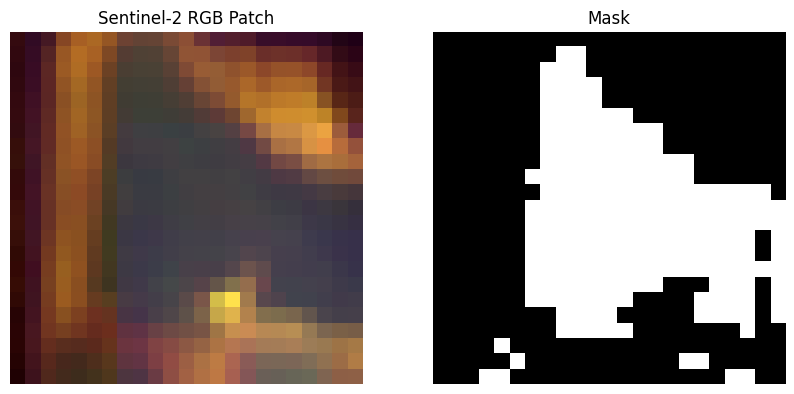

In [26]:
# Quick sanity check: visualize one random pair out of the first 31 available
# Run this cell a few times to check that you have different files and that the mask looks about right
pair_num = np.random.randint(0,30)
s2_path, mask_path = pairs[pair_num]

with rasterio.open(s2_path) as src:
    s2_img = src.read([3,2,1])  # RGB bands for Sentinel-2 (B4, B3, B2)
    s2_img = np.transpose(s2_img, (1,2,0))
    s2_img = (s2_img - s2_img.min()) / (s2_img.max() - s2_img.min()) # min/max normalization to have the lowest value be 0 and the highest be 1 to use the full range, if we would not substract the min we would lose some range

with rasterio.open(mask_path) as src:
    mask = src.read(1)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(s2_img)
plt.title("Sentinel-2 RGB Patch")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")
plt.show()

Next up we are going to prepare our training data into numpy arrays that are then able to be passed into TensorFlow. However, if we try to hold all 2000+ patches in RAM whilst we do, the Colab instance will crash. If on your own laptop, it will also die unless you have spent a lot more money than I have on mine. Furthermore, even if we had a HPC level of RAM available it is a good idea to do things in a 'memory safe' manner that means we can scale our training with more samples if we so desired it.

The safe pattern is therefore to:
1. Load a batch of patches.
2. Normalize/resize them.
3. Save them to disk (e.g. as .npy, .npz, or TFRecords/HDF5).
4. Free memory and move on.
5. Then later, when training, you stream batches directly from disk.

Here’s a disk-based pipeline with batching using numpy.savez_compressed (safe + easy to reload):

In [27]:
def resize_or_pad(arr, target_h, target_w):
    h, w = arr.shape[:2]
    c = arr.shape[2] if arr.ndim == 3 else 1

    arr = cv2.resize(
        arr,
        (target_w, target_h),
        interpolation=cv2.INTER_NEAREST if c == 1 else cv2.INTER_LINEAR)

    if arr.ndim == 2:
        arr = arr[..., np.newaxis]
    return arr


# Set storage folder
OUTPUT_DIR = "patch_store"
os.makedirs(OUTPUT_DIR, exist_ok=True)

TARGET_HEIGHT, TARGET_WIDTH = 256, 256 # Tune based on memory available
BATCH_SIZE = 100  # Tune based on memory available


X_batch, Y_batch = [], []
batch_idx = 0

for i, (s2_path, mask_path) in enumerate(tqdm(pairs, desc="Processing")):
    # tqdm is positioned so that it wraps the iterable in the for loop
    # Load Sentinel-2
    with rasterio.open(s2_path) as src:
        img = src.read().astype(np.float32)  # (bands, H, W)
        img = np.transpose(img, (1, 2, 0))  # (H, W, bands)

    # Load mask
    with rasterio.open(mask_path) as src:
        mask = src.read(1).astype(np.uint8)

    # Resize/pad
    img = resize_or_pad(img, TARGET_HEIGHT, TARGET_WIDTH)
    mask = resize_or_pad(mask, TARGET_HEIGHT, TARGET_WIDTH)

    # Normalize
    img = img / 10000.0

    # Add to batch
    X_batch.append(img)
    Y_batch.append(mask)

    # Save batch to disk when full
    if len(X_batch) >= BATCH_SIZE:
        X_batch = np.stack(X_batch)
        Y_batch = np.stack(Y_batch)

        np.savez_compressed(
            os.path.join(OUTPUT_DIR, f"batch_{batch_idx:04d}.npz"),
            X=X_batch, Y=Y_batch
        )

        # Reset
        batch_idx += 1
        X_batch, Y_batch = [], []

# Save any leftovers
if len(X_batch) > 0:
    X_batch = np.stack(X_batch)
    Y_batch = np.stack(Y_batch)
    np.savez_compressed(
        os.path.join(OUTPUT_DIR, f"batch_{batch_idx:04d}.npz"),
        X=X_batch, Y=Y_batch
    )

# By the way it is the 'tqdm' element that is providing the nifty progress bar. I always like to include it when waiting for things so that I know it is actually running.

# This block might take five to ten minutes to run as we are doing this in a linear manner (rather than parallell processing).
# An optimised version of thise code is to pass each batch to a seperate CPU thread/core.

Processing: 100%|██████████| 2066/2066 [06:46<00:00,  5.09it/s]


In [47]:
from tqdm import tqdm
import time

with tqdm(total=100) as pbar:
    for i in range(10):
        # Simulate doing a chunk of work
        time.sleep(0.5)
        # Manually update the progress bar by 10
        pbar.update(10)

100%|██████████| 100/100 [00:05<00:00, 19.95it/s]


5-10 minutes later... (mine took 8 minutes and 32 seconds), we can now move on. Because we are now not storing our training data in our RAM like we did in the lecture exercise, we have to load it in as we want it.

First up, set a bunch of parameters that we can modify in order to save our RAM load. In short, the lower these values the less RAM you will use but the worse the results:

In [28]:
# Paramaters for RAM saving
TARGET_HEIGHT, TARGET_WIDTH = 128, 128  # smaller patch -> saves RAM & compute
BANDS = 3  # RGB only -> reduces memory
BATCH_SIZE = 4  # small batch -> reduces RAM usage
MAX_TRAIN_FILES = 5  # only use subset for lab demonstration
MAX_VAL_FILES = 2

**Q1**: We have used three bands here. What is the total numnber of bands we could make available to the CNN if we so chose?

Next we find our patch files:

In [29]:
# Locate the batched .npz files
all_files = sorted(glob.glob("patch_store/*.npz"))
np.random.shuffle(all_files)

train_files = all_files[:MAX_TRAIN_FILES]
val_files   = all_files[-MAX_VAL_FILES:]

**Q2**: What is the total number of patches in our training data and the total number in our validation set? (With the parameters set as I have done in the notebook).

Tip: you can either programmatically count what is in train_files/val_files, or you can calculate it from the parameters that have been set across the cells above this one.

We then we need to change our masks to a binary label. If we were doing segmenation we would keep it as a mask, but in this case we are just trying to find patches that contain solar pannels rather than the specific solar pannel outline.

In [30]:
# Mask to binary label
def mask_to_label(mask_batch):
    """1 if any solar pixel in mask, else 0"""
    labels = (np.sum(mask_batch, axis=(1,2,3)) > 0).astype(np.float32)
    return labels

Now we need a tool to load our data in from the batched files:

In [31]:
# Data loader
def npz_loader_cls(path):
    """Load one .npz batch, downsample patches, convert to RGB, convert mask to label"""
    data = np.load(path.numpy().decode("utf-8"))
    X = data["X"]
    Y_mask = data["Y"]

    # RAM saving: pick first 3 bands only
    X = X[..., :BANDS]

    # RAM saving: downsample patches
    from skimage.transform import resize
    X_resized = np.zeros((X.shape[0], TARGET_HEIGHT, TARGET_WIDTH, BANDS), dtype=np.float32)
    for i in range(X.shape[0]):
        X_resized[i] = resize(X[i], (TARGET_HEIGHT, TARGET_WIDTH, BANDS), anti_aliasing=True)

    X = X_resized

    Y = mask_to_label(Y_mask)
    return X, Y

We can now define our training and validation datasets, which will only be actually populated with data as required, rather than loading it all into memory at once.

In [32]:
# TensorFlow dataset pipeline
def tf_wrapper(path):
    X, Y = tf.py_function(npz_loader_cls, [path], [tf.float32, tf.float32])
    X.set_shape([None, TARGET_HEIGHT, TARGET_WIDTH, BANDS])
    Y.set_shape([None])
    # Flatten file-batch into individual samples
    return tf.data.Dataset.from_tensor_slices((X, Y))

def make_cls_dataset(file_list, batch_size=BATCH_SIZE, shuffle=True, repeat=True):
    files = tf.data.Dataset.from_tensor_slices(file_list)
    if shuffle:
        files = files.shuffle(len(file_list))

    # RAM saving: stream samples via interleave
    ds = files.interleave(
        lambda f: tf_wrapper(f),
        cycle_length=4,
        num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(2048)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    if repeat:
        ds = ds.repeat()

    return ds

train_ds = make_cls_dataset(train_files, batch_size=BATCH_SIZE, shuffle=True)
val_ds   = make_cls_dataset(val_files, batch_size=BATCH_SIZE, shuffle=False, repeat=False)

**Q3**: Are we shuffling the training dataset? Are we shuffling the validation dataset?

Finally, we need to specify our model settings. We are just using a simple CNN here, the same sort as we used the lecture exercise. But, this time it has signficantly more layers and therefore parameters (but far less than you might use for your project). It may take a few minutes to set up:

In [33]:
# We are determining the input shape from one batch first
for X_sample, _ in train_ds.take(1):
    input_shape = X_sample.shape[1:]  # (H, W, bands)
    break

# Define a simple CNN
inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,177 (24.13 KB)

 Trainable params: 6,177 (24.13 KB)

 Non-trainable params: 0 (0.00 B)

**Q4**: Which type of activation funding is our final layer using and why are we using this function as our final layer?

With the model ready to train, we have one more preperation step to make. We need to count the total samples available in this particular run. This is because you can change the number of samples via the RAM paramaters earlier, and therefore we should assume in this code a static number of samples will always be available when setting our number of steps per epoch.

In [34]:
# Count the total samples
def count_samples(files):
    total = 0
    for f in files:
        total += np.load(f)["X"].shape[0]
    return total

n_train = count_samples(train_files)
n_val   = count_samples(val_files)

steps_per_epoch = max(1, n_train // BATCH_SIZE)
validation_steps = max(1, n_val // BATCH_SIZE)

Finally, we train the model! It should take 5-10 minutes to run on a free-user Colab notebook.

In [35]:
# This 'callbacks' set of instructions is a handy way to avoid wasting time
callbacks = [
    EarlyStopping(
        monitor="val_loss",          # Watch the validation loss
        patience=3,                  # If it doesn't improve for 3 epochs, stop training
        restore_best_weights=True    # Roll back to the best-performing weights
    )]

# Run the model
history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    epochs=5,  # small number for lab demonstration
    callbacks=callbacks)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 127ms/step - accuracy: 0.9146 - loss: 0.4934 - val_accuracy: 0.9085 - val_loss: 0.3821
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.9535 - loss: 0.1973 - val_accuracy: 0.9085 - val_loss: 0.3199
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 247ms/step - accuracy: 0.9397 - loss: 0.2401 - val_accuracy: 0.9085 - val_loss: 0.3567
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.9253 - loss: 0.2856 - val_accuracy: 0.9085 - val_loss: 0.4072
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.9553 - loss: 0.1907 - val_accuracy: 0.9085 - val_loss: 0.3195


Visualizie the predictions:

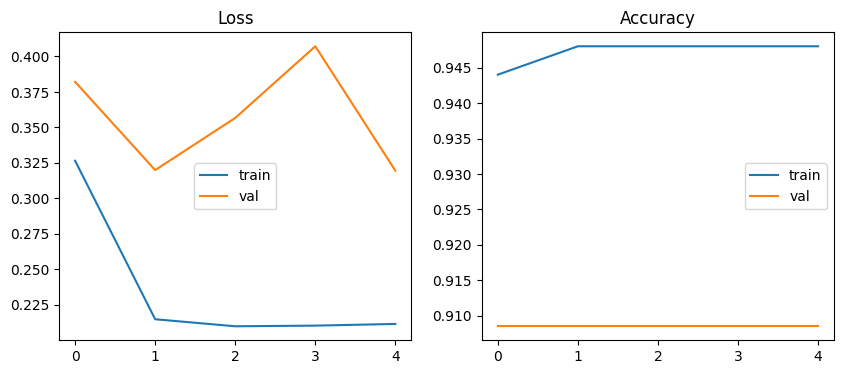

In [36]:
# Plot the training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="train")
plt.plot(history.history['val_accuracy'], label="val")
plt.title("Accuracy")
plt.legend()
plt.show()

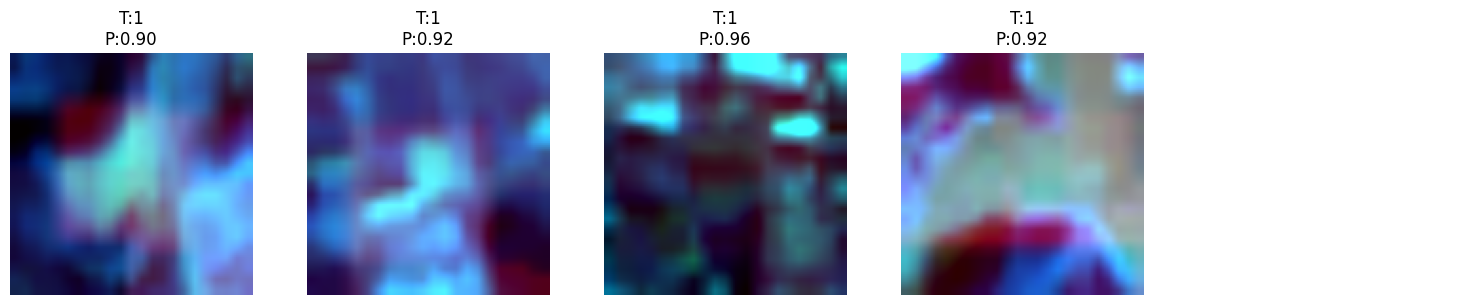

In [37]:
def show_patch_predictions_grid(dataset, model, n_rows=2, n_cols=5):
    """
    Display predictions in a grid: n_rows x n_cols
    Includes histogram stretch for better visualization of RGB patches.
    """
    def stretch(img):
        """Contrast stretch to 0–1 for display."""
        img = img.astype(np.float32)
        p2, p98 = np.percentile(img, (2, 98))
        img = np.clip((img - p2) / (p98 - p2 + 1e-6), 0, 1)
        return img

    for X, Y_true in dataset.take(1):
        # live classification of the patch using the trained model
        Y_pred = model.predict(X, verbose=0)
        n_total = min(n_rows * n_cols, X.shape[0])

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
        axes = axes.flatten()

        for i in range(n_total):
            rgb = X[i, :, :, :3].numpy()
            rgb = stretch(rgb)  # apply histogram stretch
            axes[i].imshow(rgb)
            axes[i].set_title(f"T:{int(Y_true[i].numpy())}\nP:{Y_pred[i,0]:.2f}")
            axes[i].axis("off")

        # hide any unused axes
        for i in range(n_total, len(axes)):
            axes[i].axis("off")

        plt.tight_layout()
        plt.show()

# Example
show_patch_predictions_grid(val_ds, model, n_rows=1, n_cols=5)

Remembering that this is a effectively still a toy CNN with tiny data, we can see that we have built a model that gives us a probability of the patches containing a solar pannel. We know that for all of the patchs used in this training, the answer is true...

**Q5**: Is this a robust and reliable model for the detection of solar panels in a new Sentinel 2 image that has never been seen by the model before? Explain your answer with reference to the design of the training data, the settings of the CNN and the performance statistics seen.

**Q6**: Exercise: using the materials taught in Lab 3 and given your answer to Q5, re-design your training data so that it is a robust training set for the detection of solar panels in S2 data. Your answer needs to include:
*   A paragraph that explains what you have added to the train_data and any other steps taken in order to enhance the robustness of the training.
*   A figure that demonstrates your newly added patches vs. the existing patches (remember that it needs to be publication quality).

You do not need to create a 100% solution here. I am looking for you to demonstrate an understanding of the critical design flaw in this training set (particularly for a patch based, as opposed to segmentation, approach), and to show critical thinking in how you might fix it. This may include re-sampling the existing training data, including new training data, or changing the bands being used (or all of the above).



**Q7**: Exercise: re-run the model with your new training data (remembering that I am not looking for a total solution), and further adjusted hyperparameters/RAM options. Write two paragraphs that:
1. Sets out **all the changes** you have made and the reasoning for them.
2. Asses the training and model results in terms of performance statistics, commenting on how/if your training data changes have made an impact.

You may include figures to support your analysis if you wish, remembering to present them to publication standard if you do so.